# **4. GPT Filtering**

In [17]:
import yaml

# Load configuration from YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [ ]:
API_KEY = "your_api_key_here"

In [ ]:
import pandas as pd
from tqdm import tqdm
import openai

# Config 
PARQUET_PATH = config["nli_filtered_file"]  # Path to the filtered NLI data
MODEL = "gpt-4o-mini"              
TEMPERATURE = 0
OUT_PARQUET = config["gpt_filtered_file"]  # Output file for GPT filtered data
MAX_CONCURRENT = 50  

openai.api_key = API_KEY
client = openai.OpenAI(api_key=API_KEY)

## **Prompting GPT to generate categories for edits based on a sample of 1000 edits**

In [ ]:
df = pd.read_parquet(PARQUET_PATH)[["old_sentence", "new_sentence"]]

sampled_df = df[["old_sentence", "new_sentence"]].sample(n=1000)

sample_pairs = "\n\n".join(
    f"OLD: {o}\nNEW: {n}"
    for o, n in zip(sampled_df.old_sentence, sampled_df.new_sentence)
)

taxonomy_prompt = f"""
You are a senior linguistic editor designing an error-taxonomy.

TASK
-----
Cluster the edits below into 8 – 15 non-overlapping categories
that capture the *primary* change in each pair.

GUIDELINES
• Before deciding on categories, you must read all edits and identify common patterns. Do not begin writing the taxonomy until you've considered the full range of examples.
• Categories should be specific enough to distinguish meaningfully
  different.
• Do **not** exceed 15 categories or go below 8.
• If two edits clearly belong together, they must share the same label.
• Provide a one-sentence definition so another editor knows when to use it.
• Output exactly in this format:

1. Category Name – Definition sentence.
2. ...
   ...
   
EDIT PAIRS
----------
{sample_pairs}
"""

resp = client.chat.completions.create(
    model=MODEL,
    messages=[{"role": "user", "content": taxonomy_prompt}],
    temperature=0
)

taxonomy_text = resp.choices[0].message.content.strip()
print(taxonomy_text)


## **Prompting GPT to classify edits in one of the categories**

```python

In [ ]:
import re
from concurrent.futures import ThreadPoolExecutor
import time


ALLOWED = [
    "Capitalization",
    "Punctuation",
    "Spelling / Typos",
    "Grammar",
    "Article Change",
    "Preposition Change",
    "Word Choice / Synonyms",
    "Sentence Structure",
    "Elaboration",
    "Concision",
    "Factual Change",
    "Other",
]

BASE_SYSTEM = """
You are a meticulous Dutch-language editor.

Choose **one** category from the list below that best describes the main edit.
Respond with the category label **exactly as written**. If no label fits,
respond "Other". Any label not on the list will be replaced with "Other".

CATEGORIES:
1. Capitalization – Upper/lower-case fixes (proper nouns, titles).
2. Punctuation – Adds, removes, or changes punctuation marks.
3. Spelling / Typos – Obvious misspellings or keyboard slips.
4. Grammar – Any Dutch grammar fix except articles & prepositions (verb tense, agreement, word order, negation, relative clauses, etc.).
5. Article Change – Adds, removes, or switches de/het/een (or English a/the).
6. Preposition Change – Adds or swaps a preposition (in, op, naar, voor…) affecting correctness or nuance.
7. Word Choice / Synonyms – Replaces a content word with a more suitable synonym, tone, or level of formality.
8. Sentence Structure – Reorders or rewrites clauses for better flow or coherence.
9. Elaboration – Adds information or clarifies meaning without altering the basic fact.
10. Concision – Removes redundancy or filler for brevity.
11. Factual Change – Alters real-world facts (names, dates, numbers, places).
12. Other – Use only if none of the above fit.

Return the label only. Example: Punctuation
"""

# Helper function to sanitize illegal labels
def sanitize(label: str) -> str:
    label = re.sub(r"[^A-Za-z /]", "", label).strip().title()
    # unify "Word Choice/synonyms" variations
    if label.startswith("Word Choice"):
        label = "Word Choice / Synonyms"
    return label if label in ALLOWED else "Other"

# Function to classify a single row synchronously
def classify_single_sync(args):
    idx, row = args
    user = f'OLD: "{row.old_sentence}"\nNEW: "{row.new_sentence}"'
    
    max_retries = 3
    for attempt in range(max_retries):
        try:
            if attempt > 0:
                time.sleep(0.1 * attempt)
            
            resp = client.chat.completions.create(
                model=MODEL,
                messages=[
                    {"role": "system", "content": BASE_SYSTEM},
                    {"role": "user", "content": user}
                ],
                temperature=TEMPERATURE,
                max_tokens=5,
                stop=["\n"]
            )
            raw = resp.choices[0].message.content
            return idx, sanitize(raw)
            
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"API error on row {idx}: {e}")
                return idx, "Other"
            time.sleep(2 ** attempt)

def classify_all_threaded(df):
    # Prepare arguments for threading
    args = [(idx, row) for idx, row in df.iterrows()]
    
    # ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=MAX_CONCURRENT) as executor:
        results = list(tqdm(
            executor.map(classify_single_sync, args),
            total=len(args),
            desc="Classifying"
        ))
    
    return results

# Load Data
df = (
    pd.read_parquet(PARQUET_PATH)
)
df["category"] = ""

print(f"Processing {len(df)} rows with max {MAX_CONCURRENT} concurrent requests...")

results = classify_all_threaded(df)

# Apply results to dataframe
for idx, category in results:
    df.at[idx, "category"] = category

# Save results 
df.to_parquet(OUT_PARQUET, index=False)
print(f"Saved classified data to {OUT_PARQUET}")

## **Visualize Results**


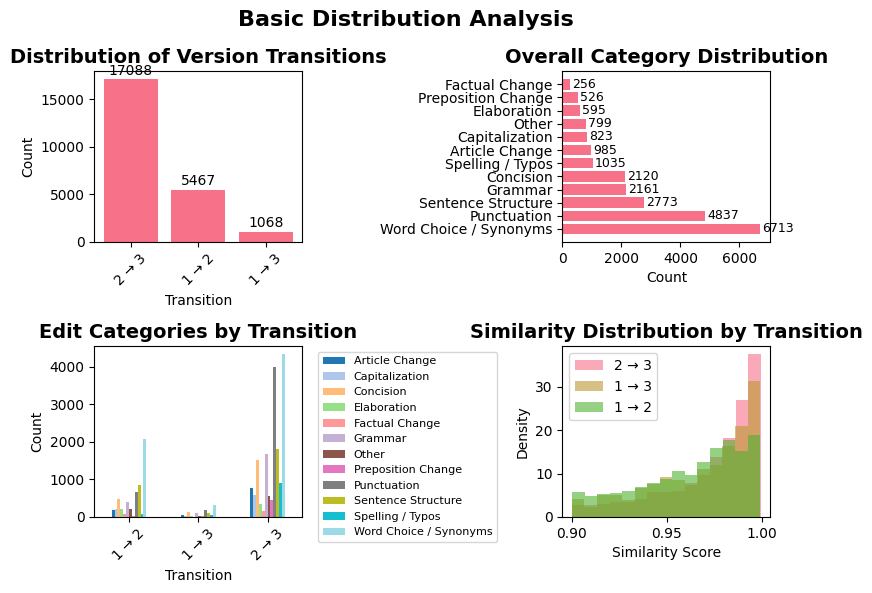

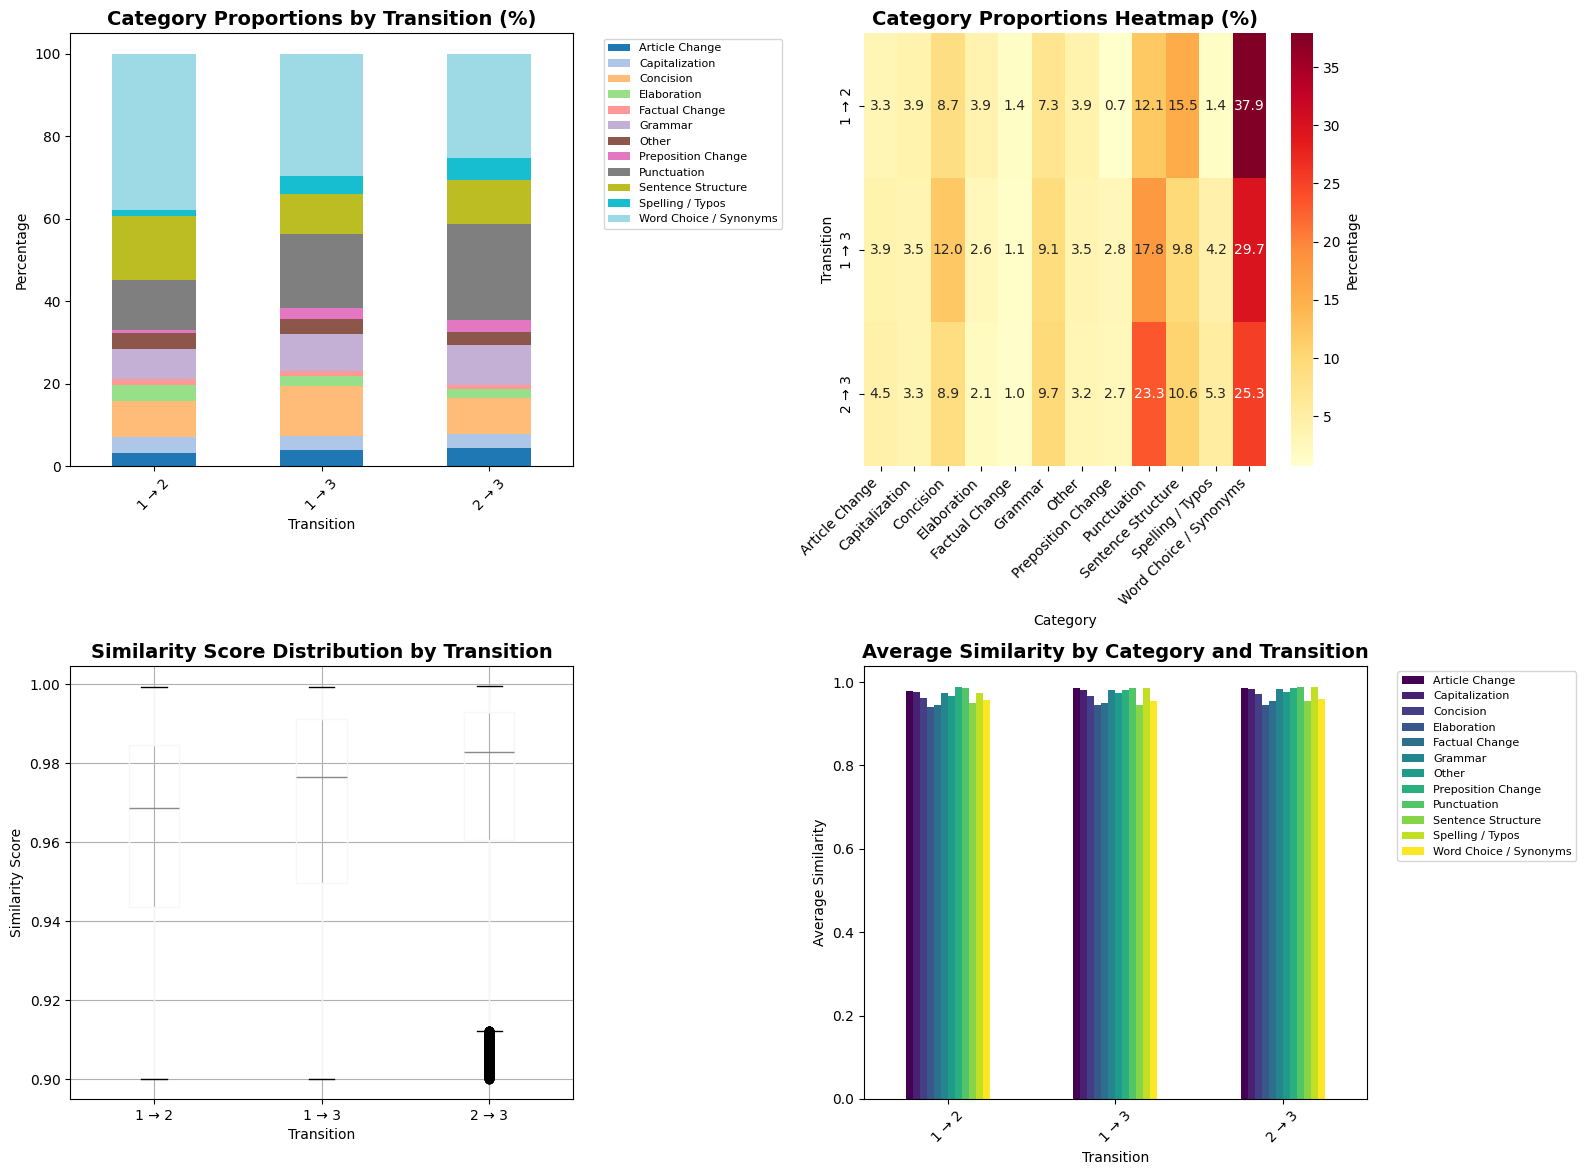

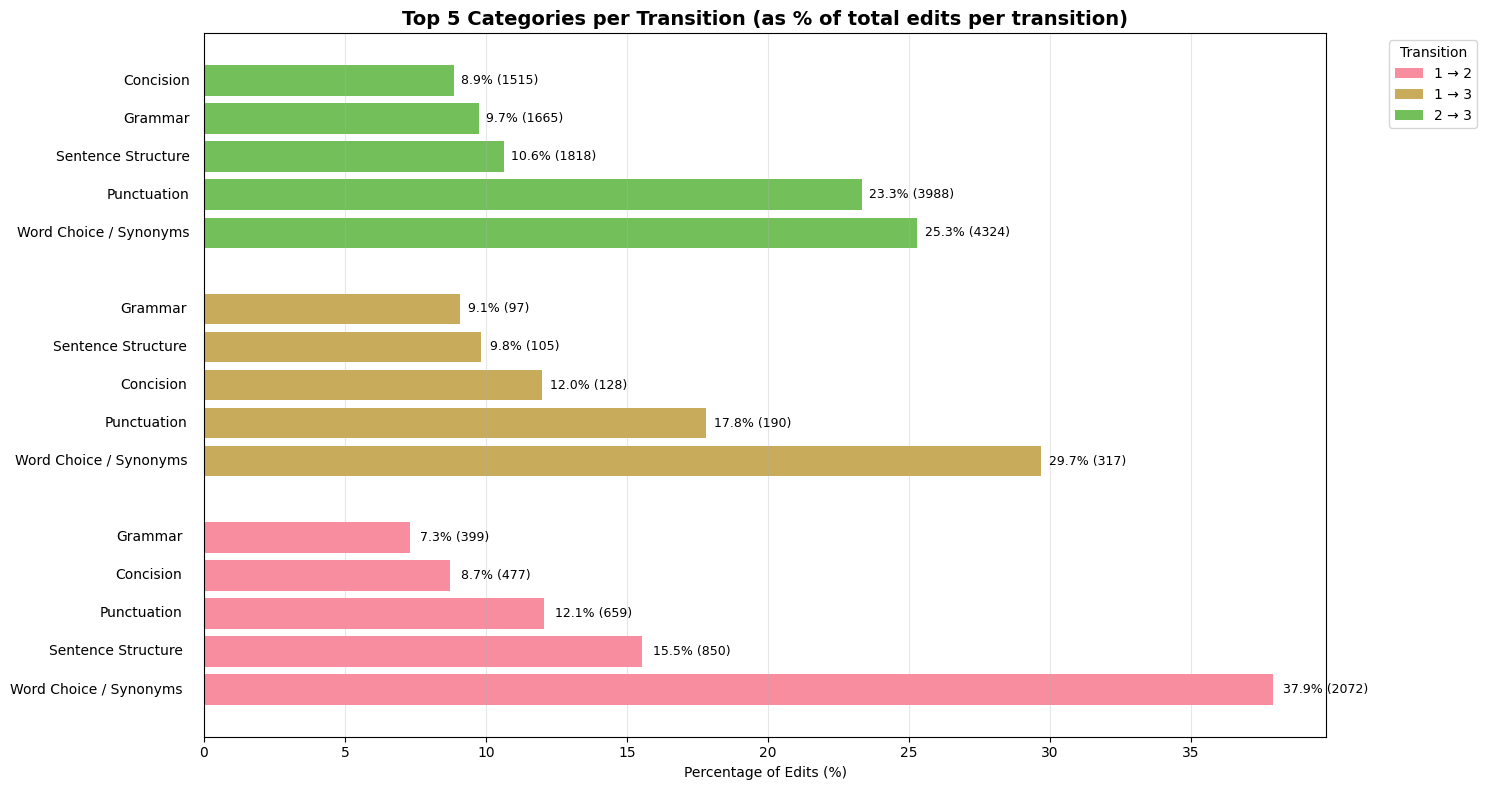

DETAILED ANALYSIS RESULTS

1. TRANSITION COUNTS:
   2 → 3: 17,088 edits (72.3%)
   1 → 2: 5,467 edits (23.1%)
   1 → 3: 1,068 edits (4.5%)

2. MOST COMMON CATEGORIES BY TRANSITION:

   1 → 2 (5,467 edits):
      1. Word Choice / Synonyms: 2072 (37.9%)
      2. Sentence Structure: 850 (15.5%)
      3. Punctuation: 659 (12.1%)
      4. Concision: 477 (8.7%)
      5. Grammar: 399 (7.3%)

   1 → 3 (1,068 edits):
      1. Word Choice / Synonyms: 317 (29.7%)
      2. Punctuation: 190 (17.8%)
      3. Concision: 128 (12.0%)
      4. Sentence Structure: 105 (9.8%)
      5. Grammar: 97 (9.1%)

   2 → 3 (17,088 edits):
      1. Word Choice / Synonyms: 4324 (25.3%)
      2. Punctuation: 3988 (23.3%)
      3. Sentence Structure: 1818 (10.6%)
      4. Grammar: 1665 (9.7%)
      5. Concision: 1515 (8.9%)

3. SIMILARITY STATISTICS BY TRANSITION:
             mean    std  min    max  count
transition                                 
1 → 2       0.962  0.027  0.9  0.999   5467
1 → 3       0.968  0.027 

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Load your data
df = pd.read_parquet(config["gpt_filtered_file"])

# Create transition column for easier grouping
df['transition'] = df['from_version'].astype(str) + ' → ' + df['to_version'].astype(str)

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Figure 1: Basic Distributions 
fig1, axes = plt.subplots(2, 2, figsize=(16, 12))
fig1.suptitle('Basic Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Overall distribution of transitions
ax1 = axes[0, 0]
transition_counts = df['transition'].value_counts()
bars = ax1.bar(transition_counts.index, transition_counts.values)
ax1.set_title('Distribution of Version Transitions', fontsize=14, fontweight='bold')
ax1.set_xlabel('Transition')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(transition_counts.values)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

# 2. Overall category distribution
ax2 = axes[0, 1]
category_counts = df['category'].value_counts()
bars2 = ax2.barh(range(len(category_counts)), category_counts.values)
ax2.set_yticks(range(len(category_counts)))
ax2.set_yticklabels(category_counts.index, fontsize=10)
ax2.set_title('Overall Category Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Count')
for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + max(category_counts.values)*0.01, bar.get_y() + bar.get_height()/2.,
             f'{int(width)}', ha='left', va='center', fontsize=9)

# 3. Category distribution by transition 
ax3 = axes[1, 0]
transition_category = pd.crosstab(df['transition'], df['category'])
transition_category.plot(kind='bar', ax=ax3, figsize=(8, 6), colormap='tab20')
ax3.set_title('Edit Categories by Transition', fontsize=14, fontweight='bold')
ax3.set_xlabel('Transition')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# 4. Similarity distribution by transition
ax4 = axes[1, 1]
transitions = df['transition'].unique()
for trans in transitions:
    subset = df[df['transition'] == trans]
    ax4.hist(subset['similarity'], alpha=0.6, label=trans, bins=15, density=True)
ax4.set_xlabel('Similarity Score')
ax4.set_ylabel('Density')
ax4.set_title('Similarity Distribution by Transition', fontsize=14, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.show()

# Figure 2: Proportional Analysis 
fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle('Proportional Analysis', fontsize=16, fontweight='bold')

# 1. Proportional stacked bar chart
ax1 = axes[0, 0]
transition_category_pct = pd.crosstab(df['transition'], df['category'], normalize='index') * 100
transition_category_pct.plot(kind='bar', stacked=True, ax=ax1, colormap='tab20')
ax1.set_title('Category Proportions by Transition (%)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Transition')
ax1.set_ylabel('Percentage')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# 2. Heatmap of transitions vs categories
ax2 = axes[0, 1]
sns.heatmap(transition_category_pct, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Percentage'}, ax=ax2)
ax2.set_title('Category Proportions Heatmap (%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Category')
ax2.set_ylabel('Transition')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# 3. Box plot of similarity scores
ax3 = axes[1, 0]
df.boxplot(column='similarity', by='transition', ax=ax3)
plt.suptitle('')  # Remove the automatic title
ax3.set_title('Similarity Score Distribution by Transition', fontsize=14, fontweight='bold')
ax3.set_xlabel('Transition')
ax3.set_ylabel('Similarity Score')

# 4. Average similarity by category and transition
ax4 = axes[1, 1]
similarity_by_cat_trans = df.groupby(['transition', 'category'])['similarity'].mean().unstack()
similarity_by_cat_trans.plot(kind='bar', ax=ax4, colormap='viridis')
ax4.set_title('Average Similarity by Category and Transition', fontsize=14, fontweight='bold')
ax4.set_xlabel('Transition')
ax4.set_ylabel('Average Similarity')
ax4.tick_params(axis='x', rotation=45)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

# Figure 3: Top Categories Analysis (Proportional) ===
fig3, ax = plt.subplots(figsize=(15, 8))
# fig3.suptitle('Top Categories by Transition', fontsize=16, fontweight='bold')

top_categories_data = []
transitions = sorted(df['transition'].unique())

for i, trans in enumerate(transitions):
    subset = df[df['transition'] == trans]
    total_for_transition = len(subset)
    top_cats = subset['category'].value_counts().head(5)
    
    # Convert to proportions
    top_cats_prop = (top_cats / total_for_transition * 100)  # As percentages
    
    y_positions = np.arange(len(top_cats_prop)) + i * (len(top_cats_prop) + 1)
    bars = ax.barh(y_positions, top_cats_prop.values, label=trans, alpha=0.8)
    
    # Add category labels with both percentage and count
    for j, (cat, prop) in enumerate(top_cats_prop.items()):
        count = top_cats.iloc[j]  # Get original count
        ax.text(-max(top_cats_prop.values)*0.02, y_positions[j], cat, 
                ha='right', va='center', fontsize=10)
        ax.text(prop + max(top_cats_prop.values)*0.01, y_positions[j], 
                f'{prop:.1f}% ({count})', ha='left', va='center', fontsize=9)

ax.set_xlabel('Percentage of Edits (%)')
ax.set_title('Top 5 Categories per Transition (as % of total edits per transition)', fontsize=14, fontweight='bold')
ax.legend(title='Transition', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_yticks([])
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# === DETAILED CONSOLE OUTPUT ===
print("=" * 60)
print("DETAILED ANALYSIS RESULTS")
print("=" * 60)

print("\n1. TRANSITION COUNTS:")
transition_summary = df['transition'].value_counts()
for trans, count in transition_summary.items():
    pct = (count / len(df)) * 100
    print(f"   {trans}: {count:,} edits ({pct:.1f}%)")

print("\n2. MOST COMMON CATEGORIES BY TRANSITION:")
for trans in sorted(df['transition'].unique()):
    subset = df[df['transition'] == trans]
    print(f"\n   {trans} ({len(subset):,} edits):")
    top_cats = subset['category'].value_counts().head(5)
    for i, (cat, count) in enumerate(top_cats.items(), 1):
        pct = (count / len(subset)) * 100
        print(f"      {i}. {cat}: {count} ({pct:.1f}%)")
    
print("\n3. SIMILARITY STATISTICS BY TRANSITION:")
similarity_stats = df.groupby('transition')['similarity'].agg(['mean', 'std', 'min', 'max', 'count'])
print(similarity_stats.round(3))

print("\n4. CATEGORY DIVERSITY:")
category_diversity = df.groupby('transition')['category'].nunique().sort_values(ascending=False)
print("   Categories per transition:")
for trans, count in category_diversity.items():
    total_possible = df['category'].nunique()
    pct = (count / total_possible) * 100
    print(f"      {trans}: {count}/{total_possible} categories ({pct:.1f}%)")

print("\n" + "=" * 60)